## Environment Setup and Imports

In [3]:
# Install or upgrade the numexpr package
!pip install --upgrade numexpr

In [4]:
# Import sagemaker and necessary libraries
import sagemaker
from sagemaker import get_execution_role
from sagemaker.image_uris import retrieve
from sagemaker.estimator import Estimator

# Import boto3 library for interacting with AWS services
import boto3
from botocore.exceptions import ClientError

# Import pandas for dataframe manipulation and analysis
import pandas as pd

# Import json for working with JSON data (for DeepAR model)
import json

# Import matplotlib and seaborn for visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Import labelencoder for encoding labels
from sklearn.preprocessing import LabelEncoder

## Data Preparation

In [21]:
df_exchangerates = pd.read_csv('ExchangeRates.csv')

In [22]:
df_exchangerates.head()

,Date,Country,Value
0,1971-01-04,Australia,1.112718
1,1971-01-05,Australia,1.113214
2,1971-01-06,Australia,1.113958
3,1971-01-07,Australia,1.113834
4,1971-01-08,Australia,1.112347


In [23]:
print("Shape of the DataFrame (rows, columns)")
print(df_exchangerates.shape)

Shape of the DataFrame (rows, columns)
(226533, 3)


In [24]:
print(df_exchangerates.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226533 entries, 0 to 226532
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Date     226533 non-null  object 
 1   Country  226533 non-null  object 
 2   Value    217806 non-null  float64
dtypes: float64(1), object(2)
memory usage: 5.2+ MB
None


In [25]:
# Convert the Date column to datetime format
df_exchangerates['Date'] = pd.to_datetime(df_exchangerates['Date'], format='%Y-%m-%d')

In [26]:
print(df_exchangerates.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226533 entries, 0 to 226532
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   Date     226533 non-null  datetime64[ns]
 1   Country  226533 non-null  object        
 2   Value    217806 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 5.2+ MB
None


In [27]:
# Printing the number of missing values for each column:
print("Missing values in each column:\n", df_exchangerates.isnull().sum())

Missing values in each column:
 Date          0
Country       0
Value      8727
dtype: int64


In [28]:
# Interpolate based on time
df_exchangerates.set_index('Date', inplace=True)

df_exchangerates['Value'] = df_exchangerates['Value'].interpolate(method='time')

df_exchangerates.reset_index(inplace=True)

In [29]:
# Checking that there are no more null values
print("Missing values in each column:\n", df_exchangerates.isnull().sum())

Missing values in each column:
 Date       0
Country    0
Value      0
dtype: int64


## Data Preparation

In [30]:
# Determine the list of countries that have exchange rate data (with the USD)
print(df_exchangerates['Country'].unique())

['Australia' 'Brazil' 'Canada' 'China' 'Denmark' 'Euro' 'Hong Kong'
 'India' 'Japan' 'Malaysia' 'Mexico' 'New Zealand' 'Norway' 'Singapore'
 'South Africa' 'South Korea' 'Sweden' 'Switzerland' 'Taiwan' 'Thailand'
 'United Kingdom' 'Venezuela']


In [31]:
# Wellington FX does not trade currencies from the following countries due to low demand
untraded_countries = ['India', 'Malaysia', 'South Korea', 'Venezuela']

# Remove all rows with these countries
df_exchangerates = df_exchangerates[~df_exchangerates['Country'].apply(lambda x: any(item in x for item in untraded_countries))]

# Check that they have been removed from the list
print(df_exchangerates['Country'].unique())

['Australia' 'Brazil' 'Canada' 'China' 'Denmark' 'Euro' 'Hong Kong'
 'Japan' 'Mexico' 'New Zealand' 'Norway' 'Singapore' 'South Africa'
 'Sweden' 'Switzerland' 'Taiwan' 'Thailand' 'United Kingdom']


In [32]:
# Replacing country names to the currency acronyms
df_exchangerates['Country'] = df_exchangerates['Country'].replace({
    'Australia': 'AUD',
    'Brazil': 'BRL',
    'Canada': 'CAD',
    'China': 'CNY',
    'Denmark': 'DKK',
    'Euro': 'EUR',
    'Hong Kong': 'HKD',
    'Japan': 'JPY',
    'Mexico': 'MXN',
    'New Zealand': 'NZD',
    'Norway': 'NOK',
    'Singapore': 'SGD',
    'South Africa': 'ZAR',
    'Sweden': 'SEK',
    'Switzerland': 'CHF',
    'Taiwan': 'TWD',
    'Thailand': 'THB',
    'United Kingdom': 'GBP'
})

# Checking that the change was successful
print(df_exchangerates['Country'].unique())

['AUD' 'BRL' 'CAD' 'CNY' 'DKK' 'EUR' 'HKD' 'JPY' 'MXN' 'NZD' 'NOK' 'SGD'
 'ZAR' 'SEK' 'CHF' 'TWD' 'THB' 'GBP']


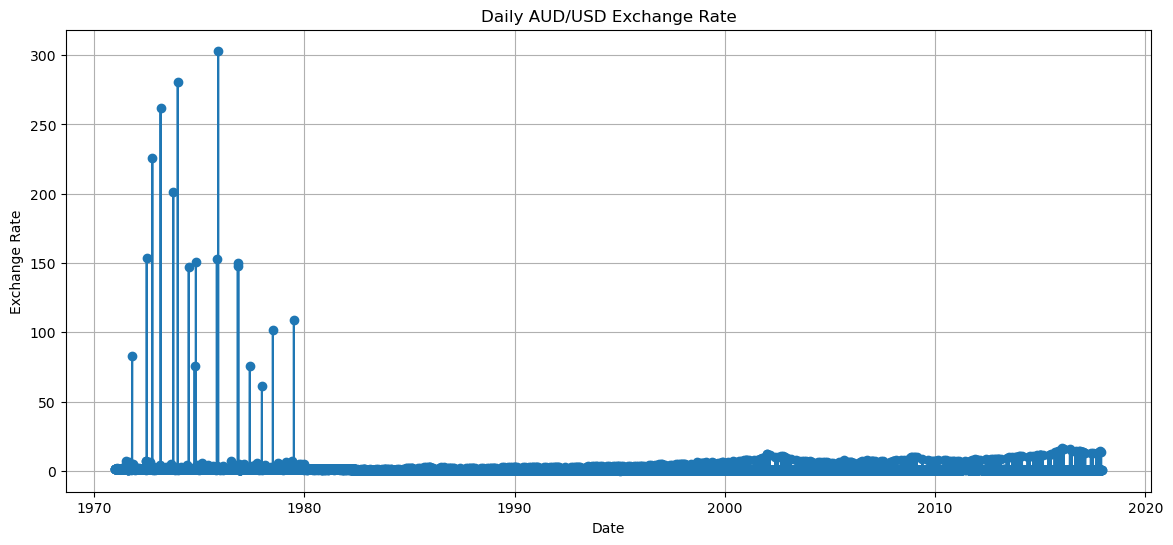

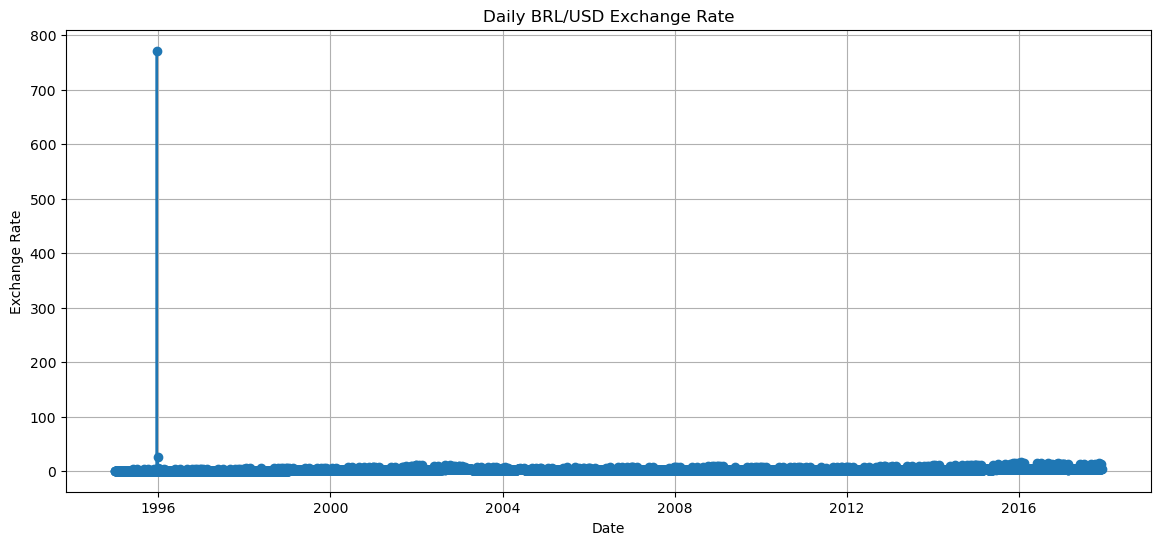

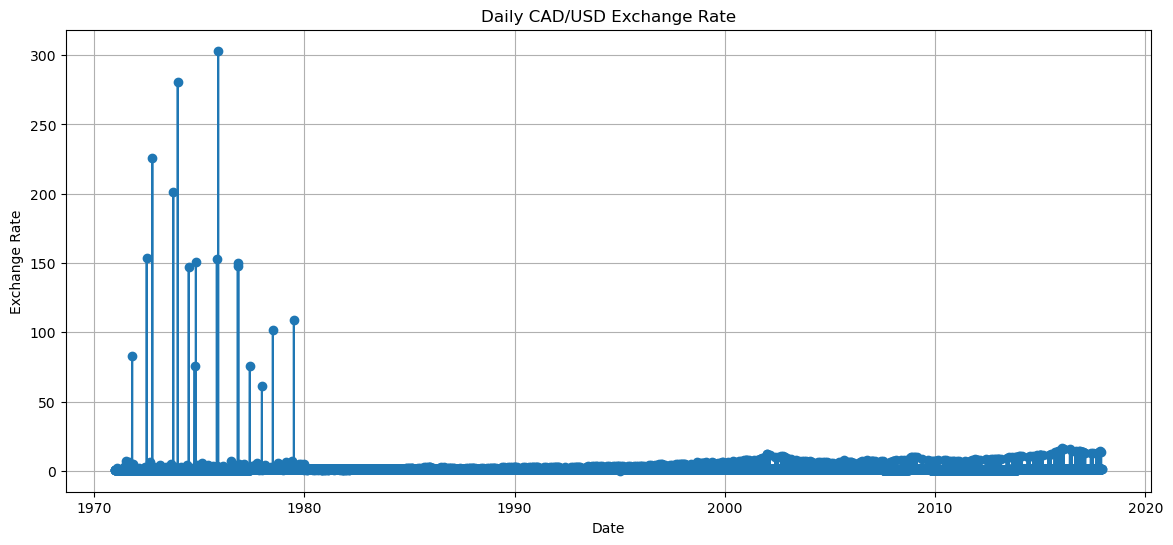

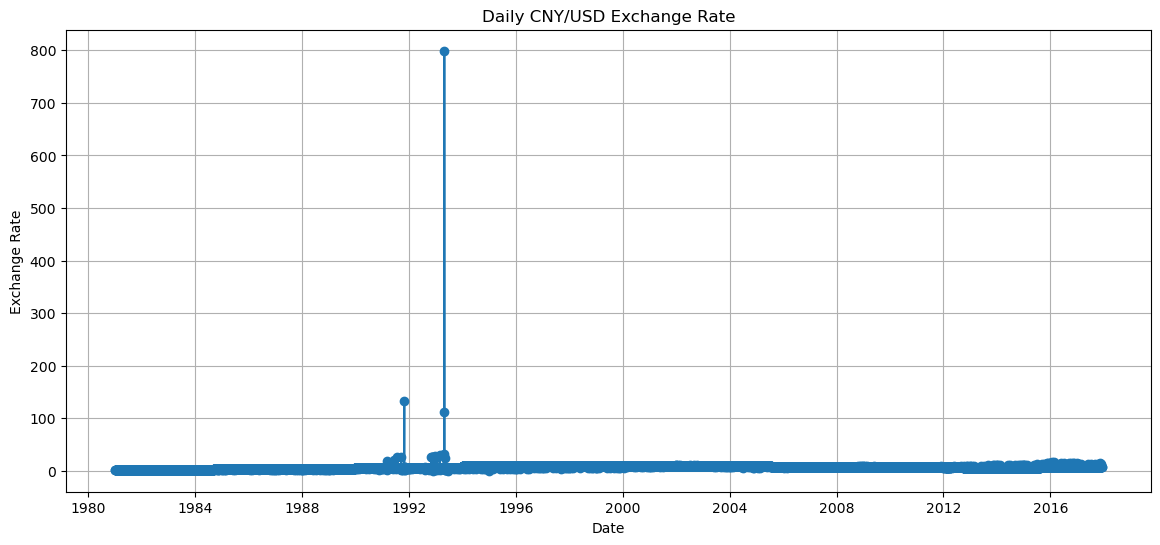

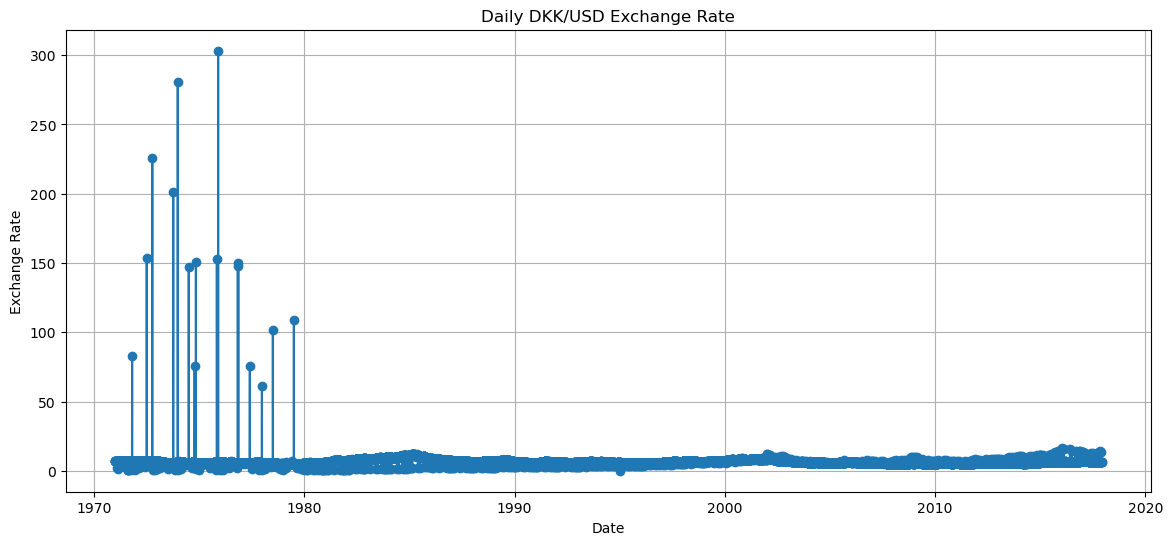

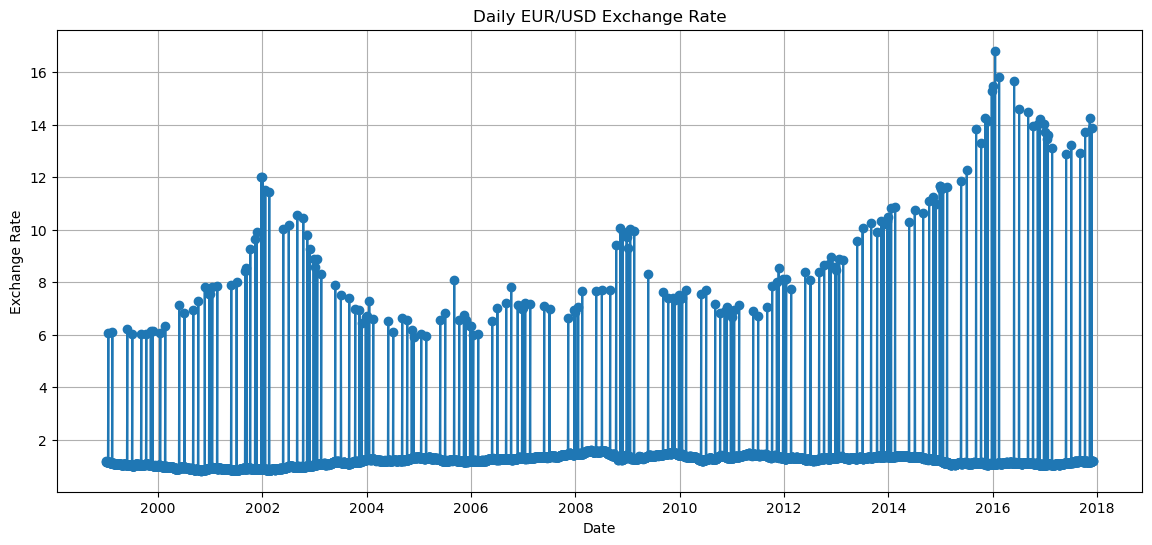

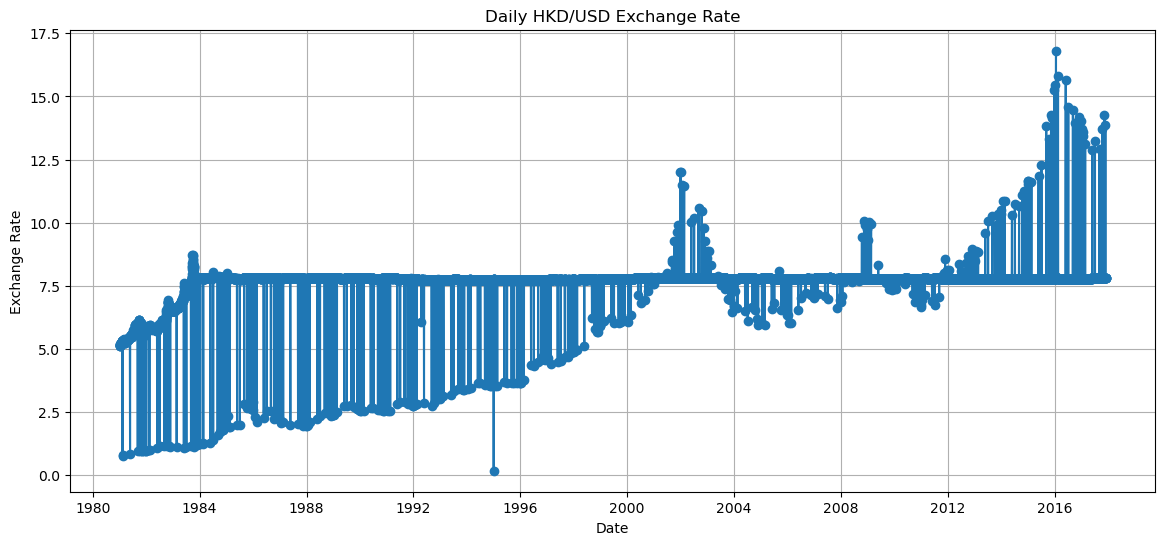

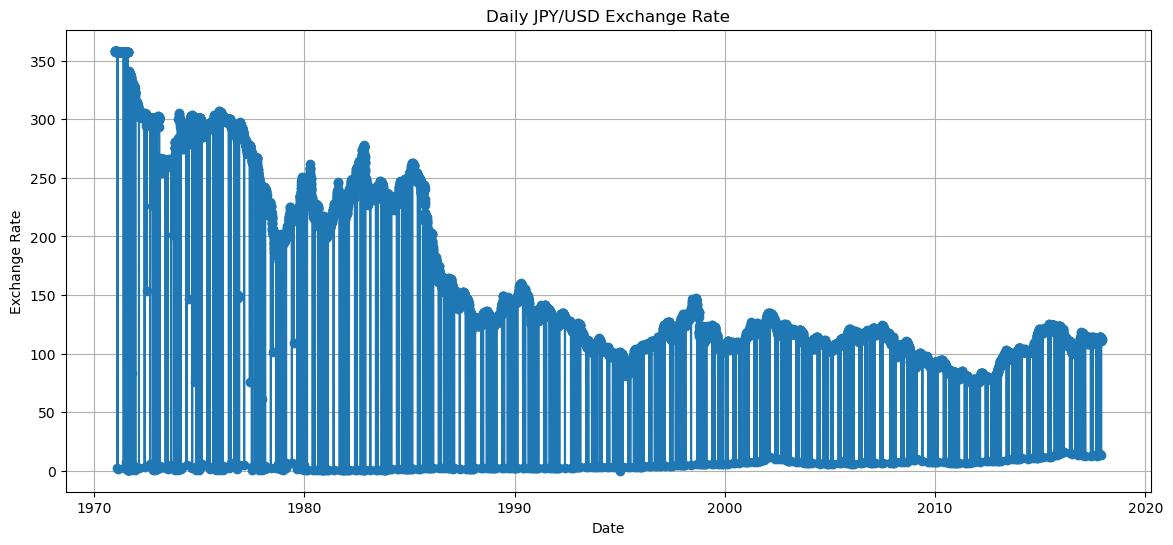

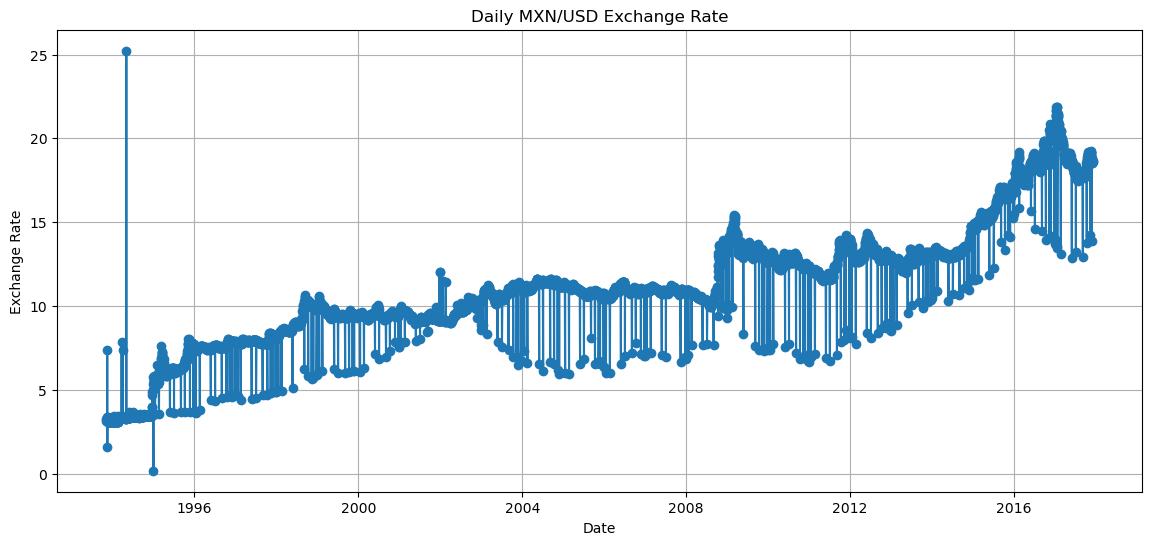

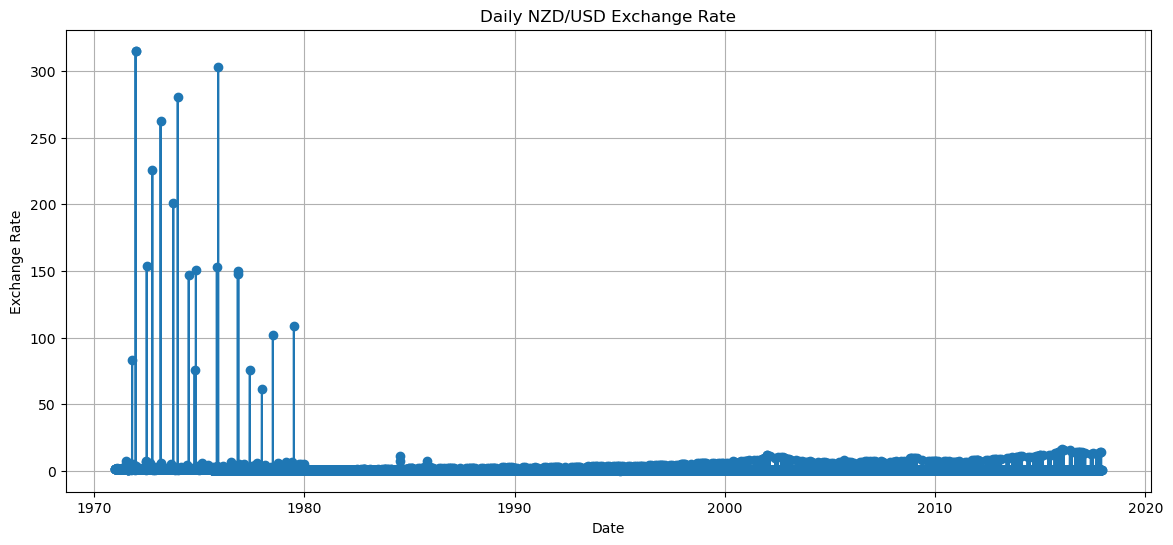

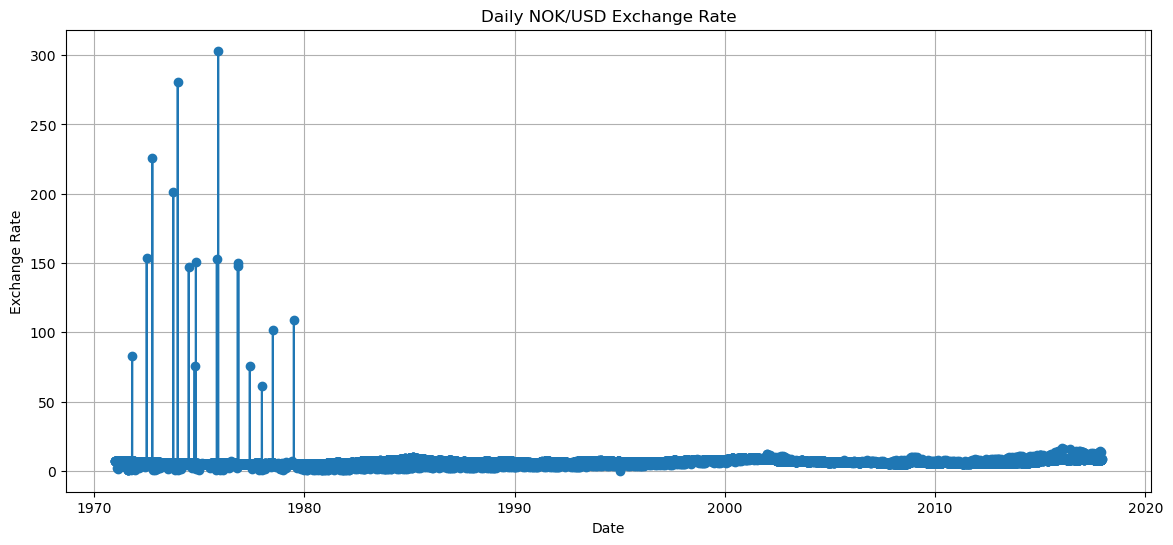

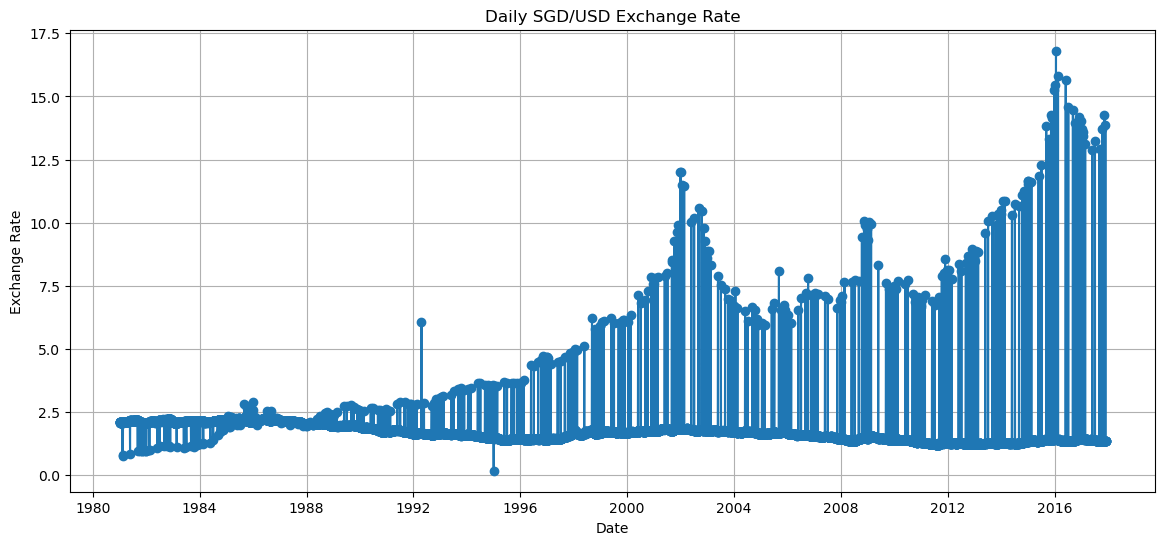

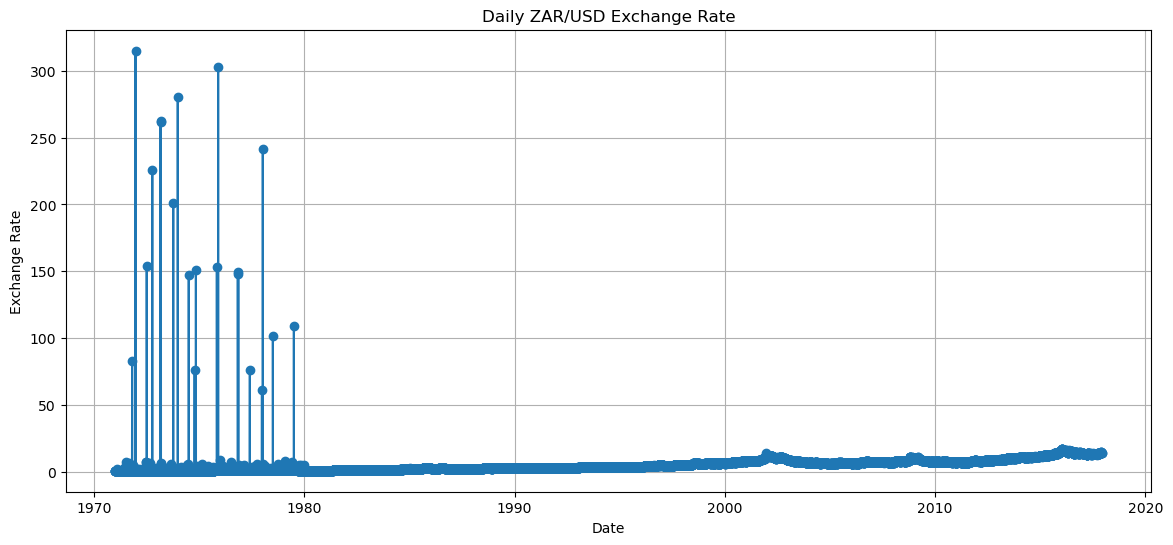

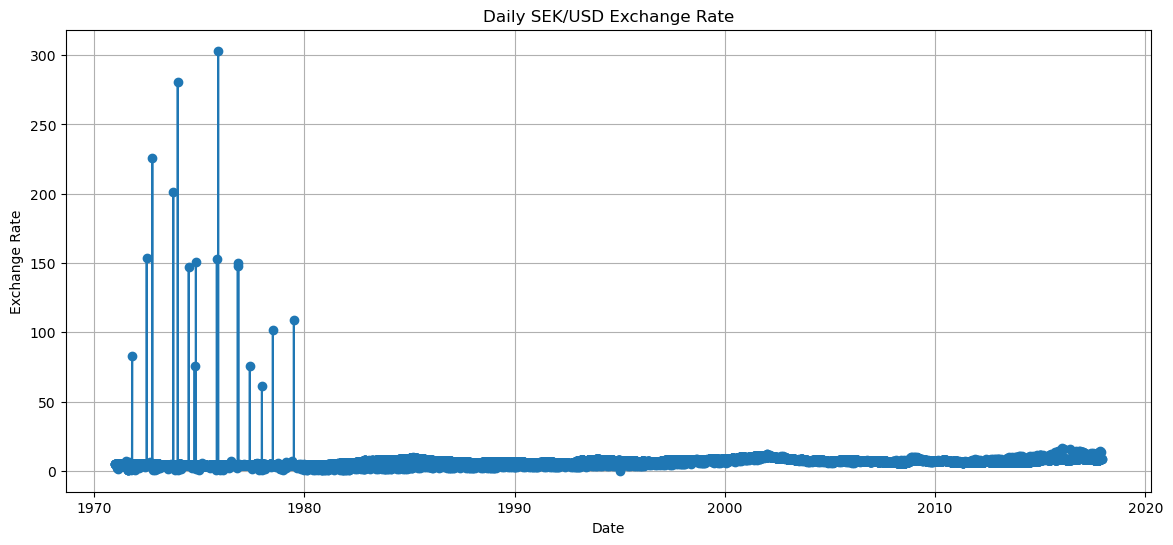

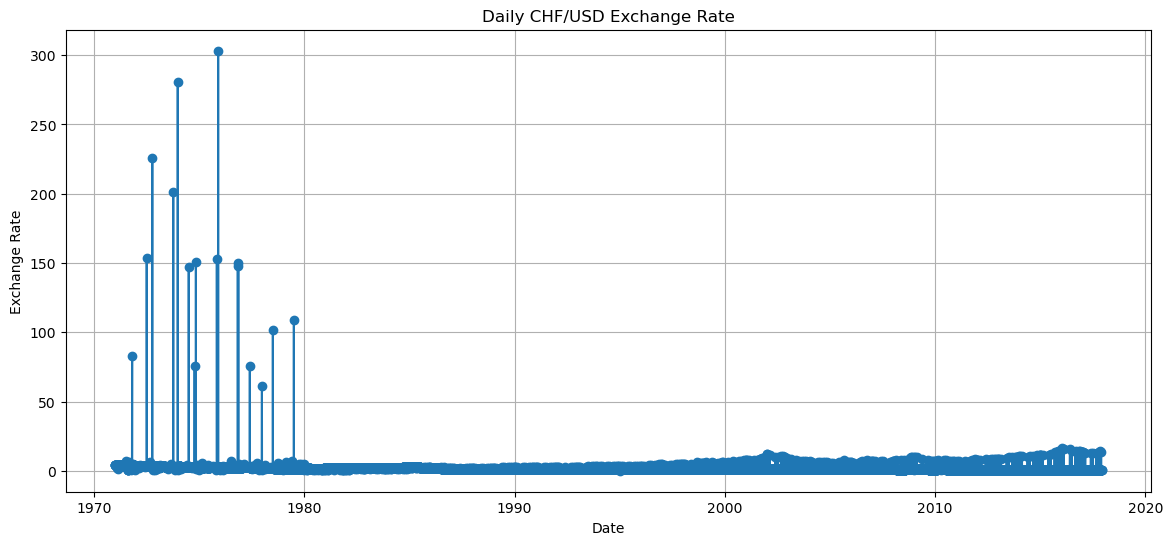

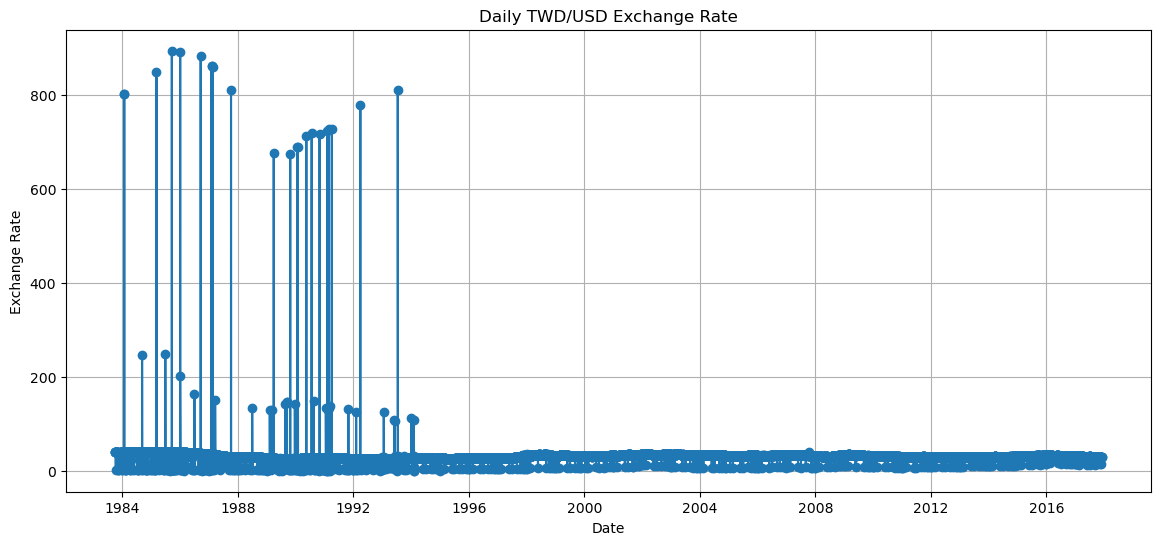

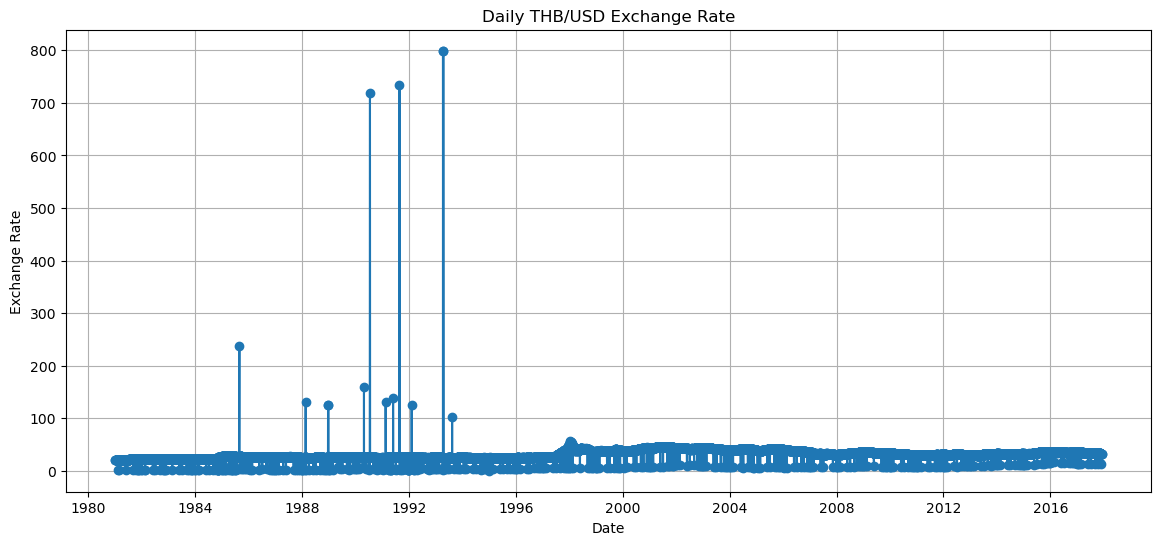

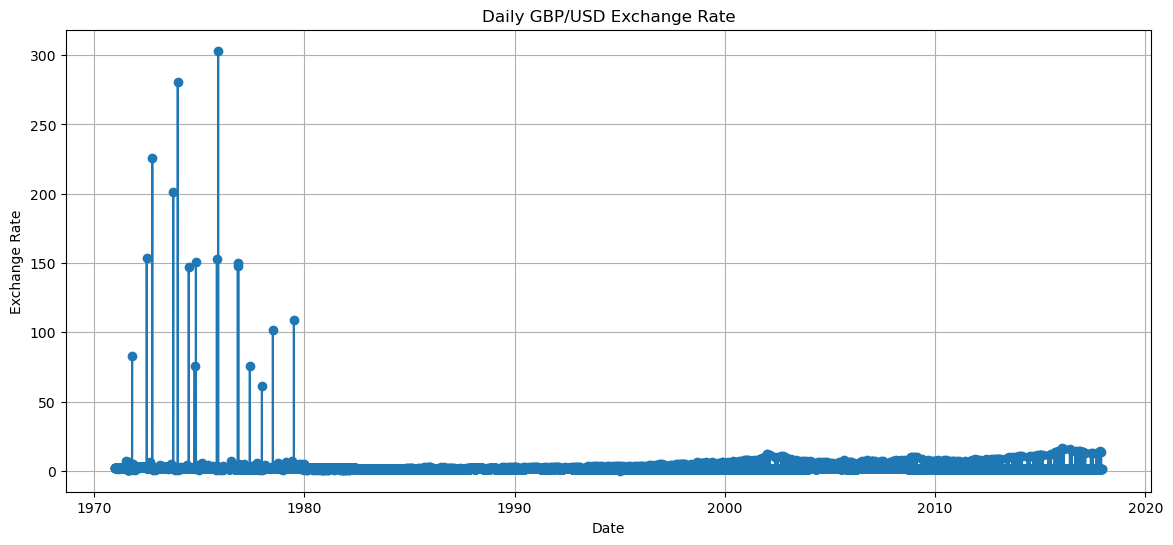

In [34]:
# Creating separate line plots for each country
countries = df_exchangerates['Country'].unique()

for country in countries:
    country_data = df_exchangerates[df_exchangerates['Country'] == country]
    plt.figure(figsize=(14,6))
    plt.plot(country_data['Date'], country_data['Value'], marker='o')
    plt.xlabel('Date')
    plt.ylabel('Exchange Rate')
    plt.title(f'Daily {country}/USD Exchange Rate')
    plt.grid(True)
    plt.show()

In [ ]:
# Finding the variance and standard deviation for each currency
variance_by_currency = df_exchangerates.groupby('Country')['Value'].var()

print(variance_by_currency)

## Data Preparation for DeepAR Model Training

In [35]:
# Creating a label encoder isntance and encode the 'Country' column
label_encoder = LabelEncoder()
df_exchangerates['Country'] = label_encoder.fit_transform(df_exchangerates['Country'])

country_code_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

print("Country Code Mapping:")
print(country_code_mapping)

Country Code Mapping:
{'AUD': 0, 'BRL': 1, 'CAD': 2, 'CHF': 3, 'CNY': 4, 'DKK': 5, 'EUR': 6, 'GBP': 7, 'HKD': 8, 'JPY': 9, 'MXN': 10, 'NOK': 11, 'NZD': 12, 'SEK': 13, 'SGD': 14, 'THB': 15, 'TWD': 16, 'ZAR': 17}


In [36]:
def convert_to_deepar_json(df, filename, is_test=False):
    grouped = df.groupby('Country')
    time_series = []
    for _, group in grouped:
        # Creating a record for each time series
        record = {
            "start": str(group['Date'].min()),
            "target": group['Value'].tolist(),
            "cat": [int(group['Country'].iloc[0])]
        }
        if is_test:
            # For the test set, including only the last 'prediction_length' points
            record["target"] = record["target"][-prediction_length:]
        time_series.append(record)
    
    # Write the time series to a JSON file
    with open(filename, 'w') as f:
        for ts in time_series:
            f.write(json.dumps(ts)+'\n')

# Set the prediction length
prediction_length = 7 # Adjust as needed

# Split the data into training and test sets
train_df = df_exchangerates.copy()
test_df = df_exchangerates.groupby('Country').apply(lambda x: x.tail(prediction_length)).reset_index(drop=True)

# Ensure that the test set has the last 'prediction length' points for each time series
test_df = test_df.groupby('Country').filter(lambda x: len(x) == prediction_length)

# Convert the training and test sets to DeepAR JSON format
convert_to_deepar_json(train_df, 'exchangerates_train.json')
convert_to_deepar_json(test_df, 'exchangerates_test.json', is_test=True)

/tmp/ipykernel_7463/2970861408.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_df = df_exchangerates.groupby('Country').apply(lambda x: x.tail(prediction_length)).reset_index(drop=True)


## SageMaker Session and Environment Setup

In [37]:
# Creating a SageMaker session to interact with the environment
sagemaker_session = sagemaker.Session()

# Getting the role for the current notebook instance
role = get_execution_role()

# Getting the AWS region from the session
region = sagemaker_session.boto_region_name

# Specifying the DeepAR container
image_uri = retrieve('forecasting-deepar', region)

# Defining the default S3 bucket
bucket = sagemaker_session.default_bucket()

# Defining the prefix where the data will be stored
prefix = 'sagemaker/exchangerates/timeseries'

# Defining the paths for the local training and testing json files
local_train = 'exchangerates_train.json'
local_test = 'exchangerates_test.json'

# Uploading the local json files to the specified S3 bucket and prefix
train_uri = sagemaker_session.upload_data(local_train, bucket=bucket, key_prefix=prefix)
test_uri = sagemaker_session.upload_data(local_test, bucket=bucket, key_prefix=prefix)

# Printing the role, region, and URIs for the training and testing data
print("Execution Role ARN:", role)
print("AWS Region:", region)
print("Training Data S3 URI:", train_uri)
print("Test Data S3 URI:", test_uri)

Execution Role ARN: arn:aws:iam::654654391924:role/LabRole
AWS Region: us-east-1
Training Data S3 URI: s3://sagemaker-us-east-1-654654391924/sagemaker/exchangerates/timeseries/exchangerates_train.json
Test Data S3 URI: s3://sagemaker-us-east-1-654654391924/sagemaker/exchangerates/timeseries/exchangerates_test.json


## Estimator Configuration for DeepAR Algorithm Training

In [38]:
# Defining an Estimator for the DeepAR algorithm
deepar_estimator = Estimator(
    sagemaker_session=sagemaker_session,
    image_uri=image_uri,
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path=f's3://{bucket}/{prefix}/output',
    base_job_name='exchangerates-deepar-forecasting'
)

# Setting the hyperparameters for the DeepAR algorithm
deepar_estimator.set_hyperparameters(
    time_freq='D',
    context_length=30,
    prediction_length=7,
    epochs=20,
    early_stopping_patience=10,
    num_dynamic_feat='auto',
    cardinality='auto'
)

## Model Training with DeepAR Estimator

In [39]:
# Defining the URIs where the data is to train the model
data_channels = {
    'train': train_uri,
    'test': test_uri
}

# Training the DeepAR estimator using the stored data
deepar_estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: exchangerates-deepar-forecasting-2024-03-27-18-42-23-372


2024-03-27 18:42:23 Starting - Starting the training job...
2024-03-27 18:42:39 Starting - Preparing the instances for training...
2024-03-27 18:43:11 Downloading - Downloading input data...
2024-03-27 18:43:46 Downloading - Downloading the training image.....................
2024-03-27 18:47:02 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
[03/27/2024 18:47:09 INFO 140164338636608] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patien

## HyperParameter Tuning

In [ ]:
from sagemaker.tuner import HyperparameterTuner, IntegerParameter, ContinuousParameter

#Finding the average length of the time-series
grouped = df_exchangerates.groupby('Country')
time_series_lengths = []

for country, group in grouped:
    length = len(group)
    time_series_lengths.append(length)
    
average_length = sum(time_series_lengths)/len(time_series_lengths)
print(average_length)

# Adjust hyperparameter ranges based on the average time series length
hyperparameter_ranges = {
    'epochs': IntegerParameter(50, 200),
    'context_length': IntegerParameter(14, 60),
    'mini_batch_size': IntegerParameter(32, 256),
    'learning_rate': ContinuousParameter(1e-5, 1e-1),
    'num_cells': IntegerParameter(24, 128),
    'dropout_rate': ContinuousParameter(0.1, 0.2),
    'embedding_dimension': IntegerParameter(16, 64)
}

# Creating the tuner
tuner = HyperparameterTuner(
    estimator=deepar_estimator,
    objective_metric_name='test:RMSE',
    objective_type='Minimize',
    hyperparameter_ranges=hyperparameter_ranges,
    max_jobs=5,
    max_parallel_jobs=1,
    base_tuning_job_name='exchangerates-deepar-tuning'
)

# Starting the tuning job
tuner.fit(inputs=data_channels)

INFO:sagemaker:Creating hyperparameter tuning job with name: exchangerates-deepar-240327-2023


10390.777777777777
..........................................................................................................................................................................................................................................................................................

## Model Deployment to SageMaker Endpoint

In [40]:
# Specifying the endpoint and configuration names - they must be the same
endpoint_name = 'exchangerates-endpoint'
endpoint_config_name = 'exchangerates-endpoint'

In [41]:
# Creating endpoint configuration deletion function as this will be called before and after using the endpoint
def delete_sagemaker_endpoint_config(endpoint_config_name):
    sagemaker = boto3.client('sagemaker', region_name=region)
    try:
        response = sagemaker.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
        
        if response:
            sagemaker.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
            print(f"Endpoint configuration '{endpoint_config_name}' has been deleted.")
        
        return True
    
    except Exception as e:
        error_message = str(e)
        
        if "Could not find endpoint configuration" in error_message:
            print(f"Endpoint configuration '{endpoint_config_name}' not found. No action taken.")
            return True
        else:
            print(f"Error deleting SageMaker endpoint configuration: {error_message}")
            return False

# Creating endpoint deletion function as this will be called before and after using the endpoint
def delete_sagemaker_endpoint(endpoint_name):
    sagemaker = boto3.client('sagemaker', region_name=region)
    try:
        response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
        
        if response:
            sagemaker.delete_endpoint(EndpointName=endpoint_name)
            print(f"Endpoint '{endpoint_name}' has been deleted.")
        
        return True
    
    except Exception as e:
        error_message = str(e)
        
        if "Could not find endpoint" in error_message:
            print(f"Endpoint '{endpoint_name}' not found. No action taken.")
            return True
        else:
            print(f"Error deleting SageMaker endpoint: {error_message}")
            return False


In [44]:
# Ensuring that the endpoint and configuration are deleted / do not exist before creating a new endpoint
result_endpoint_config = delete_sagemaker_endpoint_config(endpoint_config_name)
result_endpoint = delete_sagemaker_endpoint(endpoint_name)

if result_endpoint_config and result_endpoint:
    print("Success!")
else:
    print("Failed.")

Endpoint configuration 'exchangerates-endpoint' has been deleted.
Endpoint 'exchangerates-endpoint' not found. No action taken.
Success!


In [45]:
# Deploy trained model to an endpoint
predictor = deepar_estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
    serializer=sagemaker.serializers.JSONSerializer(),
    deserializer=sagemaker.deserializers.JSONDeserializer(),
    endpoint_name=endpoint_name
)

print(f'Endpoint name: {predictor.endpoint_name}')
print(f'Endpoint configuration name:{endpoint_config_name}')

INFO:sagemaker:Creating model with name: exchangerates-deepar-forecasting-2024-03-27-18-52-42-494
INFO:sagemaker:Creating endpoint-config with name exchangerates-endpoint
INFO:sagemaker:Creating endpoint with name exchangerates-endpoint


------------!Endpoint name: exchangerates-endpoint
Endpoint configuration name:exchangerates-endpoint-config


## Prediction by Country

Currency Code List:
AUD: 0
BRL: 1
CAD: 2
CHF: 3
CNY: 4
DKK: 5
EUR: 6
GBP: 7
HKD: 8
JPY: 9
MXN: 10
NOK: 11
NZD: 12
SEK: 13
SGD: 14
THB: 15
TWD: 16
ZAR: 17


Enter the currency code for prediction: 6


            Date  Country     Value
57261 2017-11-27        6  1.191043
57262 2017-11-28        6  1.187790
57263 2017-11-29        6  1.185818
57264 2017-11-30        6  1.189768
57265 2017-12-01        6  1.191043

Predicted Rates for 7 days from 2017-12-01 onward
        Date     Value
0 2017-12-01  1.015006
1 2017-12-02  0.882543
2 2017-12-03  0.758304
3 2017-12-04  0.848963
4 2017-12-05  0.855706
5 2017-12-06  0.989586
6 2017-12-07  0.998138


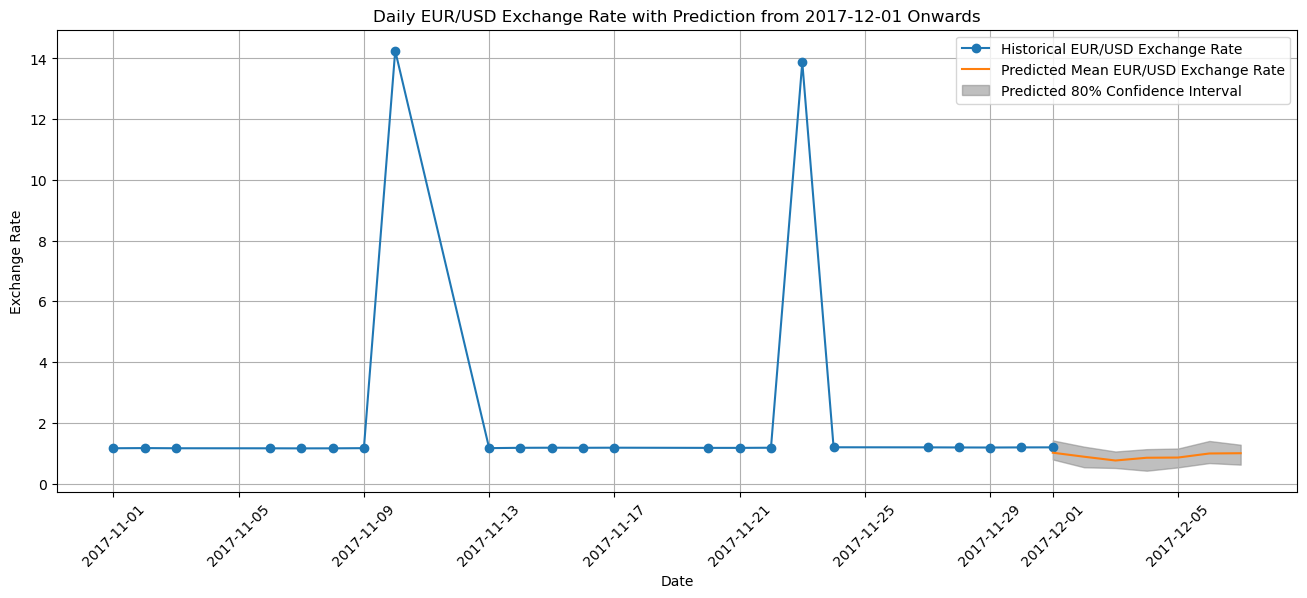

In [61]:
# Displaying the list of countries
print("Currency Code List:")
for currency, code in country_code_mapping.items():
    print(f"{currency}: {code}")

# Prompt for the currency code
selected_currency_code = int(input("Enter the currency code for prediction:"))

# Find the currency name corresponding to the selected code
selected_currency_name = [currency for currency, code in country_code_mapping.items() if code == selected_currency_code][0]

# Creating a new DataFrame with just the data of the selected country
selected_currency_rates = df_exchangerates[df_exchangerates['Country'] == selected_currency_code]

print(selected_currency_rates.tail())

# Finding the last date with historical data - this is where the prediction begins
last_date = selected_currency_rates['Date'].max().strftime('%Y-%m-%d')

prediction_input = {
    "instances": [{"start": last_date, "target": selected_currency_rates['Value'].tolist(), "cat": [selected_currency_code]}],
    "configuration": {"num_samples": 100, "output_types": ["mean", "quantiles"], "quantiles": ["0.1", "0.9"]}
}

# Invoke the endpoint for prediction
sagemaker_runtime = boto3.client('sagemaker-runtime')
response = sagemaker_runtime.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType='application/json',
    Body=json.dumps(prediction_input)
)

# Parse the prediction response
predictions = json.loads(response['Body'].read().decode())
predicted_means = predictions['predictions'][0]['mean']
predicted_quantiles = predictions['predictions'][0]['quantiles']
predicted_lower_quantile = predicted_quantiles['0.1']
predicted_upper_quantile = predicted_quantiles['0.9']

# Creating a DataFrame for the predicted sales
predicted_dates = pd.date_range(start=last_date, periods=len(predicted_means), freq='D')
predicted_rates = pd.DataFrame({'Date': predicted_dates, 'Value': predicted_means})

# Printing the prediction
print(f"\nPredicted Rates for 7 days from {last_date} onward")
print(predicted_rates)

# Filtering for just the last 30 days for the selected country
last_30_days = selected_currency_rates[selected_currency_rates['Date'] >= (selected_currency_rates['Date'].max() - pd.Timedelta(days=30))]

# Plotting the historical exchange rates
plt.figure(figsize=(16,6))
plt.plot(last_30_days['Date'], last_30_days['Value'], marker='o', linestyle='-', label=f'Historical {selected_currency_name}/USD Exchange Rate')

# Plotting the predicted exchange rates
plt.plot(predicted_dates, predicted_means, label=f'Predicted Mean {selected_currency_name}/USD Exchange Rate')

# Plotting the confidence interval of the predicted rates
plt.fill_between(predicted_dates, predicted_lower_quantile, predicted_upper_quantile, color='gray', alpha=0.5, label='Predicted 80% Confidence Interval')

# Adding labels and showing the plot
plt.title(f'Daily {selected_currency_name}/USD Exchange Rate with Prediction from {last_date} Onwards')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

## Deleting the Endpoint After Use

In [ ]:
# Calling the deletion functions to terminate the endpoint and configuration
result_endpoint_config = delete_sagemaker_endpoint_config(endpoint_config_name)
result_endpoint = delete_sagemaker_endpoint(endpoint_name)

if result_endpoint_config and result_endpoint:
    print("Success!")
else:
    print("Failed.")